Code to run the analysis where we test whether moral opportunists switch between guilt- and inequity-averse brain patterns

In [1]:
import warnings, os, sys, glob, matplotlib, scipy
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
matplotlib.rcParams['pdf.fonttype'] = 42 #To make text readable by Illustrator
import numpy as np
import pandas as pd
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, collapse_mask
from nltools.stats import threshold, one_sample_permutation, two_sample_permutation, correlation_permutation
from nilearn.plotting import plot_roi
base_dir = '/project/3014018.02/analysis_mri/DataSharingCollection/'
sys.path.append('%sCode/Tools/'%base_dir)
import FigureTools;

## Load behavioral clusters

In [2]:
fittedParams = pd.read_csv(os.path.join(base_dir,
    'Results/2.Behavior-ClusterModel/ParticipantClustering.csv'),index_col=0)
print fittedParams.head()
subNums = np.array(fittedParams['sub'].unique())
print subNums
print len(subNums)

   sub     model     theta       phi    SSE         AIC         BIC Sample  \
0  124  MP_ppSOE  0.340718  0.055082   65.0   -7.882301   -3.220835    old   
1  126  MP_ppSOE  0.078473  0.000799  205.0   79.413025   84.074491    old   
2  128  MP_ppSOE  0.030199  0.059205  255.0   96.000296  100.661762    old   
3  129  MP_ppSOE  0.206195 -0.095803  203.0   78.667921   83.329387    old   
4  130  MP_ppSOE  0.078536 -0.017041  323.0  113.965843  118.627309    old   

   clust ClustName  
0      1        GR  
1      4        MO  
2      3        IA  
3      4        MO  
4      4        MO  
[124 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 148 150 151 152 153 154 156 157 158 159 160 161 162 164 165
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 189
 190 191 192]
57


In [3]:
fittedParams['ClustName'].value_counts()

IA    24
MO    21
GR     7
GA     5
Name: ClustName, dtype: int64

## Load parcellation

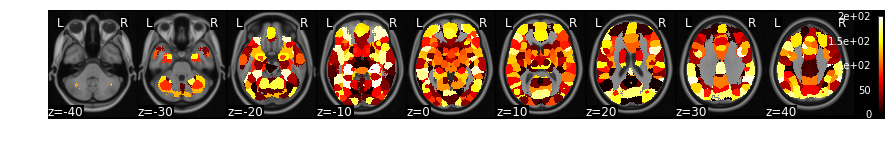

In [4]:
nparcel = 200
roi = Brain_Data(os.path.join(base_dir,'Data/6.Parcellation/whole_brain_cluster_labels_PCA=100_k=%s.nii.gz' % nparcel))
roi.plot()
roi_x = expand_mask(roi)

## Load GA/IA clustering results

In [5]:
stats_all = pd.read_csv(os.path.join(base_dir,
     'Results/4.fMRI-PatternClustering/PatternConjunctionStats.csv'),index_col=0)
stats_all.head()

,clust,parcel,x4_mean,x4_p,x2_mean,x6_mean,x2_p,x6_p
7,IA,54,0.077456,0.0008,0.117732,0.072080,0.0000,0.0000
9,GA,58,0.215051,0.0252,0.161420,0.145234,0.0042,0.0132
10,IA,58,0.035350,0.0364,0.056215,0.039126,0.0004,0.0100
13,IA,63,0.134033,0.0014,0.120784,0.104232,0.0000,0.0000
16,IA,79,0.080525,0.0000,0.082835,0.073891,0.0000,0.0000


[ 54  58  63  79  87  95 128 135 140 146 155 158 173 183]
[ 58  95 128 140 158 173] [ 54  58  63  79  87 135 140 146 155 183]


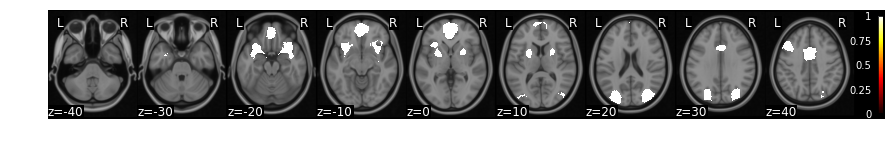

In [13]:
# Select active parcels
parcels = np.unique(stats_all.loc[(stats_all['clust']!='MO'),'parcel'])
parcelsGA = np.unique(stats_all.loc[(stats_all['clust']=='GA'),'parcel'])
parcelsIA = np.unique(stats_all.loc[(stats_all['clust']=='IA'),'parcel'])
print parcels
print parcelsGA, parcelsIA
totalROI = collapse_mask(roi_x[parcels],auto_label=False)
totalROI.plot();

parcelsCommon = np.intersect1d(parcelsGA,parcelsIA)
parcelsGAonly = np.setdiff1d(parcelsGA,parcelsIA)
parcelsIAonly = np.setdiff1d(parcelsIA,parcelsGA)

## Load MO and GAIA beta maps

In [14]:
GAnums = np.array(fittedParams.loc[fittedParams['ClustName']=='GA','sub'])
IAnums = np.array(fittedParams.loc[fittedParams['ClustName']=='IA','sub'])
MOnums = np.array(fittedParams.loc[fittedParams['ClustName']=='MO','sub'])
print len(GAnums),len(IAnums),len(MOnums)

5 24 21


In [ ]:
# Load beta maps
dat_GA_x2 = Brain_Data()
dat_GA_x4 = Brain_Data()
dat_GA_x6 = Brain_Data()
dat_IA_x2 = Brain_Data()
dat_IA_x4 = Brain_Data()
dat_IA_x6 = Brain_Data()
dat_MO_x2 = Brain_Data()
dat_MO_x4 = Brain_Data()
dat_MO_x6 = Brain_Data()
screen = 'Mult'
for sub in GAnums:
    dat_GA_x2 = dat_GA_x2.append(Brain_Data(glob.glob(os.path.join(base_dir,
                    'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X2')))).mean())
    dat_GA_x4 = dat_GA_x4.append(Brain_Data(glob.glob(os.path.join(base_dir,
                    'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X4')))).mean())
    dat_GA_x6 = dat_GA_x6.append(Brain_Data(glob.glob(os.path.join(base_dir,
                    'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X6')))).mean())
for sub in IAnums:
    dat_IA_x2 = dat_IA_x2.append(Brain_Data(glob.glob(os.path.join(base_dir,
                    'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X2')))).mean())
    dat_IA_x4 = dat_IA_x4.append(Brain_Data(glob.glob(os.path.join(base_dir,
                    'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X4')))).mean())
    dat_IA_x6 = dat_IA_x6.append(Brain_Data(glob.glob(os.path.join(base_dir,
                    'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X6')))).mean())
for sub in MOnums:
    dat_MO_x2 = dat_MO_x2.append(Brain_Data(glob.glob(os.path.join(base_dir,
                        'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X2')))).mean())
    dat_MO_x4 = dat_MO_x4.append(Brain_Data(glob.glob(os.path.join(base_dir,
                        'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X4')))).mean())
    dat_MO_x6 = dat_MO_x6.append(Brain_Data(glob.glob(os.path.join(base_dir,
                        'Data/5.fMRI-BetaMaps/p%s_%s%s*.nii'%(sub,screen,'X6')))).mean())

In [16]:
# Standardize per parcel per subject
dat_GA_x2_zscore = dat_GA_x2.copy()
dat_GA_x4_zscore = dat_GA_x4.copy()
dat_GA_x6_zscore = dat_GA_x6.copy()
dat_IA_x2_zscore = dat_IA_x2.copy()
dat_IA_x4_zscore = dat_IA_x4.copy()
dat_IA_x6_zscore = dat_IA_x6.copy()
dat_MO_x2_zscore = dat_MO_x2.copy()
dat_MO_x4_zscore = dat_MO_x4.copy()
dat_MO_x6_zscore = dat_MO_x6.copy()
parcelLocs = []
for parcel in range(200):
    print parcel,
    parcelLocs.append(np.where(roi_x[parcel].data==1))
print ''
for subInd,sub in enumerate(GAnums):
    print sub,
    subMapX2 = dat_GA_x2_zscore[subInd].copy()
    subMapX4 = dat_GA_x4_zscore[subInd].copy()
    subMapX6 = dat_GA_x6_zscore[subInd].copy()
    subDatX2 = subMapX2.data
    subDatX4 = subMapX4.data
    subDatX6 = subMapX6.data
    for parcel in range(200):
        parcelLoc = parcelLocs[parcel][0]
        subDatX2[parcelLoc] = ss.zscore(subDatX2[parcelLoc])
        subDatX4[parcelLoc] = ss.zscore(subDatX4[parcelLoc])
        subDatX6[parcelLoc] = ss.zscore(subDatX6[parcelLoc])
    subMapX2.data = subDatX2
    subMapX4.data = subDatX4
    subMapX6.data = subDatX6
    dat_GA_x2_zscore[subInd] = subMapX2
    dat_GA_x4_zscore[subInd] = subMapX4
    dat_GA_x6_zscore[subInd] = subMapX6
for subInd,sub in enumerate(IAnums):
    print sub,
    subMapX2 = dat_IA_x2_zscore[subInd].copy()
    subMapX4 = dat_IA_x4_zscore[subInd].copy()
    subMapX6 = dat_IA_x6_zscore[subInd].copy()
    subDatX2 = subMapX2.data
    subDatX4 = subMapX4.data
    subDatX6 = subMapX6.data
    for parcel in range(200):
        parcelLoc = parcelLocs[parcel][0]
        subDatX2[parcelLoc] = ss.zscore(subDatX2[parcelLoc])
        subDatX4[parcelLoc] = ss.zscore(subDatX4[parcelLoc])
        subDatX6[parcelLoc] = ss.zscore(subDatX6[parcelLoc])
    subMapX2.data = subDatX2
    subMapX4.data = subDatX4
    subMapX6.data = subDatX6
    dat_IA_x2_zscore[subInd] = subMapX2
    dat_IA_x4_zscore[subInd] = subMapX4
    dat_IA_x6_zscore[subInd] = subMapX6
for subInd,sub in enumerate(MOnums):
    print sub,
    subMapX2 = dat_MO_x2_zscore[subInd].copy()
    subMapX4 = dat_MO_x4_zscore[subInd].copy()
    subMapX6 = dat_MO_x6_zscore[subInd].copy()
    subDatX2 = subMapX2.data
    subDatX4 = subMapX4.data
    subDatX6 = subMapX6.data
    for parcel in range(200):
        parcelLoc = parcelLocs[parcel][0]
        subDatX2[parcelLoc] = ss.zscore(subDatX2[parcelLoc])
        subDatX4[parcelLoc] = ss.zscore(subDatX4[parcelLoc])
        subDatX6[parcelLoc] = ss.zscore(subDatX6[parcelLoc])
    subMapX2.data = subDatX2
    subMapX4.data = subDatX4
    subMapX6.data = subDatX6
    dat_MO_x2_zscore[subInd] = subMapX2
    dat_MO_x4_zscore[subInd] = subMapX4
    dat_MO_x6_zscore[subInd] = subMapX6

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
142 146 154 158 186 128 132 133 138 140 141 143 144 145 150 151 152 153 157 165 172 175 178 179 181 183 190 191 192 126 129 130 131 134 135 137 139 156 161 162 164 171 173 174 176 177 180 185 187 189


In [17]:
for dat in [dat_GA_x2,dat_GA_x4,dat_GA_x6,
            dat_GA_x2_zscore,dat_GA_x4_zscore,dat_GA_x6_zscore,
            dat_IA_x2,dat_IA_x4,dat_IA_x6,
            dat_IA_x2_zscore,dat_IA_x4_zscore,dat_IA_x6_zscore,
            dat_MO_x2,dat_MO_x4,dat_MO_x6,
            dat_MO_x2_zscore,dat_MO_x4_zscore,dat_MO_x6_zscore,
           ]:
    print dat.shape()

(5, 238955)
(5, 238955)
(5, 238955)
(5, 238955)
(5, 238955)
(5, 238955)
(24, 238955)
(24, 238955)
(24, 238955)
(24, 238955)
(24, 238955)
(24, 238955)
(21, 238955)
(21, 238955)
(21, 238955)
(21, 238955)
(21, 238955)
(21, 238955)


In [18]:
# Should be nearly 0:
print dat_IA_x2_zscore[np.random.randint(0,len(dat_IA_x2_zscore),size=1)].data[roi_x[np.random.randint(0,199,1)].data==1].mean()
print dat_GA_x6_zscore[np.random.randint(0,len(dat_GA_x6_zscore),size=1)].data[roi_x[np.random.randint(0,199,1)].data==1].mean()
print dat_MO_x2_zscore[np.random.randint(0,len(dat_MO_x2_zscore),size=1)].data[roi_x[np.random.randint(0,199,1)].data==1].mean()
# Should be non 0:
print dat_IA_x2[np.random.randint(0,len(dat_IA_x2),size=1)].data[roi_x[np.random.randint(0,199,1)].data==1].mean()
print dat_GA_x6[np.random.randint(0,len(dat_GA_x6),size=1)].data[roi_x[np.random.randint(0,199,1)].data==1].mean()
print dat_MO_x2[np.random.randint(0,len(dat_MO_x2),size=1)].data[roi_x[np.random.randint(0,199,1)].data==1].mean()

2.90275e-08
0.0
-2.0454141e-08
0.06848267
0.26974496
-0.15846312


## Per parcel, compute similarity of MO z maps to GA-IA z-diff map

In [19]:
# Distance
simMethod = 'correlation'
includeX4 = False
sim_zdiffs_all = pd.DataFrame()
for parcel in parcels:
    parcelDat_GA_x2_zscore = dat_GA_x2_zscore.apply_mask(roi_x[parcel])
    parcelDat_GA_x4_zscore = dat_GA_x4_zscore.apply_mask(roi_x[parcel])
    parcelDat_GA_x6_zscore = dat_GA_x6_zscore.apply_mask(roi_x[parcel])
    parcelDat_IA_x2_zscore = dat_IA_x2_zscore.apply_mask(roi_x[parcel])
    parcelDat_IA_x4_zscore = dat_IA_x4_zscore.apply_mask(roi_x[parcel])
    parcelDat_IA_x6_zscore = dat_IA_x6_zscore.apply_mask(roi_x[parcel])
    # Mean
    mean_GA_x2 = parcelDat_GA_x2_zscore.mean()
    mean_GA_x4 = parcelDat_GA_x4_zscore.mean()
    mean_GA_x6 = parcelDat_GA_x6_zscore.mean()
    mean_IA_x2 = parcelDat_IA_x2_zscore.mean()
    mean_IA_x4 = parcelDat_IA_x4_zscore.mean()
    mean_IA_x6 = parcelDat_IA_x6_zscore.mean()
    # Difference
    mean_zdiff_x2 = mean_GA_x2 - mean_IA_x2
    mean_zdiff_x4 = mean_GA_x4 - mean_IA_x4
    mean_zdiff_x6 = mean_GA_x6 - mean_IA_x6
    sim_zdiff_x2 = dat_MO_x2_zscore.apply_mask(roi_x[parcel]).similarity(
        mean_zdiff_x2,method=simMethod)
    sim_zdiff_x4 = dat_MO_x4_zscore.apply_mask(roi_x[parcel]).similarity(
        mean_zdiff_x4,method=simMethod)
    sim_zdiff_x6 = dat_MO_x6_zscore.apply_mask(roi_x[parcel]).similarity(
        mean_zdiff_x6,method=simMethod)
    if includeX4:
        sim_zdiffs = pd.DataFrame(np.transpose(np.vstack([sim_zdiff_x2,sim_zdiff_x4,sim_zdiff_x6])),
                              columns=['x2','x4','x6'])
    else:
        sim_zdiffs = pd.DataFrame(np.transpose(np.vstack([sim_zdiff_x2,sim_zdiff_x6])),
                              columns=['x2','x6'])
    sim_zdiffs = sim_zdiffs.melt(var_name = 'Condition', value_name='GA > IA similarity')
    sim_zdiffs['parcel'] = parcel
    sim_zdiffs_all = sim_zdiffs_all.append(sim_zdiffs)

In [20]:
nMO = len(dat_MO_x2)
sim_zdiffs_all['sub'] = np.tile(range(nMO),[1,len(parcels)*(2+includeX4)]).T

In [21]:
sim_zdiffs_all.to_csv(os.path.join(base_dir,'Results/5.fMRI-MOswitching',
                       'MO_sim_to_GAIA.csv'))

## Load data

In [6]:
sim_zdiffs_all = pd.read_csv(os.path.join(base_dir,'Results/5.fMRI-MOswitching',
                       'MO_sim_to_GAIA.csv'),index_col=0)

In [7]:
sim_zdiffs_all.head()

,Condition,GA > IA similarity,parcel,sub
0,x2,-0.090721,54,0
1,x2,-0.187678,54,1
2,x2,-0.689366,54,2
3,x2,-0.238098,54,3
4,x2,-0.499934,54,4


In [8]:
sim_zdiffs_all.parcel.unique()

array([ 54,  58,  63,  79,  87,  95, 128, 135, 140, 146, 155, 158, 173,
       183])

## Plot / test

/home/decision/jervbaa/.conda/envs/hmtg_fmri_nc/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Parcel 54, t = 5.40, p = 0.0000, p-Bonferroni-corrected = 0.0004*
Parcel 58, t = 0.31, p = 0.7588, p-Bonferroni-corrected = 10.6229
Parcel 63, t = -0.97, p = 0.3414, p-Bonferroni-corrected = 4.7801
Parcel 79, t = 1.64, p = 0.1173, p-Bonferroni-corrected = 1.6422
Parcel 87, t = -0.21, p = 0.8356, p-Bonferroni-corrected = 11.6985
Parcel 95, t = 1.04, p = 0.3085, p-Bonferroni-corrected = 4.3189
Parcel 128, t = 0.28, p = 0.7806, p-Bonferroni-corrected = 10.9286
Parcel 135, t = 4.27, p = 0.0004, p-Bonferroni-corrected = 0.0053*
Parcel 140, t = 0.31, p = 0.7599, p-Bonferroni-corrected = 10.6387
Parcel 146, t = 4.92, p = 0.0001, p-Bonferroni-corrected = 0.0011*
Parcel 155, t = 1.68, p = 0.1094, p-Bonferroni-corrected = 1.5317
Parcel 158, t = 1.72, p = 0.1010, p-Bonferroni-corrected = 1.4136
Parcel 173, t = 1.66, p = 0.1117, p-Bonferroni-corrected = 1.5635
Parcel 183, t = -0.61, p = 0.5519, p-Bonferroni-corrected = 7.7264


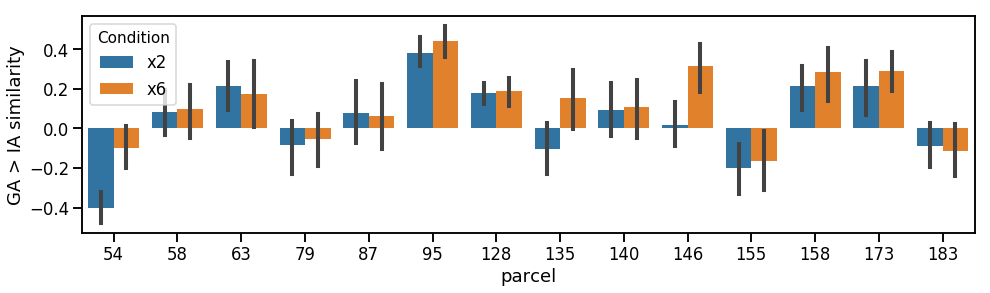

In [25]:
# Plot:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=[np.min([len(parcels)*4,16]),4])
sns.barplot(data=sim_zdiffs_all,x='parcel',y='GA > IA similarity',hue='Condition',ax=ax)
stats_all = pd.DataFrame(columns=['parcel','t','p','p_corr'])
for parcel in parcels:
    stats = ss.ttest_rel(sim_zdiffs_all.loc[(sim_zdiffs_all['parcel']==parcel) &
                                (sim_zdiffs_all['Condition']=='x6'),'GA > IA similarity'],
                         sim_zdiffs_all.loc[(sim_zdiffs_all['parcel']==parcel) &
                                (sim_zdiffs_all['Condition']=='x2'),'GA > IA similarity'])
    t_val = stats[0]
    p_corr = stats[1]*len(parcels)
    if (p_corr < 0.05) & (t_val > 0):
        sigstars = '*'
    else:
        sigstars = ''
    print 'Parcel %i, t = %.2f, p = %.4f, p-Bonferroni-corrected = %.4f%s'%(parcel,t_val,stats[1],p_corr,sigstars)
    stats_all = stats_all.append(pd.DataFrame([[parcel,t_val,stats[1],p_corr]],columns=stats_all.columns))
plt.show()

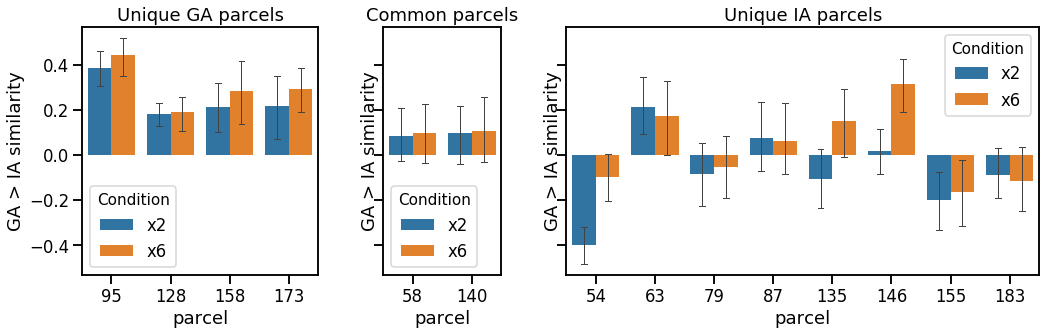

In [26]:
# Split by GA/IA map
fig,ax = plt.subplots(1,3,figsize=[15,5],sharey=True,
          gridspec_kw={'width_ratios':[float(len(parcelsGAonly))/float(len(parcels)),
                                       float(len(parcelsCommon))/float(len(parcels)),
                                       float(len(parcelsIAonly))/float(len(parcels))]})
sns.barplot(data=sim_zdiffs_all.loc[sim_zdiffs_all['parcel'].isin(parcelsGAonly)],
            x='parcel',hue='Condition',y='GA > IA similarity',errwidth=1,capsize=.1,ax=ax[0])
ax[0].set_title('Unique GA parcels')
sns.barplot(data=sim_zdiffs_all.loc[sim_zdiffs_all['parcel'].isin(parcelsCommon)],
            x='parcel',hue='Condition',y='GA > IA similarity',errwidth=1,capsize=.1,ax=ax[1])
ax[1].set_title('Common parcels')
sns.barplot(data=sim_zdiffs_all.loc[sim_zdiffs_all['parcel'].isin(parcelsIAonly)],
            x='parcel',hue='Condition',y='GA > IA similarity',errwidth=1,capsize=.1,ax=ax[2])
ax[2].set_title('Unique IA parcels')
plt.tight_layout()

## Summarize over parcels: subject mean over parcel-wise similarities

In [ ]:
nMO = len(dat_MO_x2)
meanSimilarities_allROIs = pd.DataFrame(columns=['sub','cond','GAsim'])
includeX4 = False
if includeX4:
    conds = ['x2','x4','x6']
else:
    conds = ['x2','x6']
for subInd in range(nMO):
    subDat = sim_zdiffs_all.loc[(sim_zdiffs_all['sub']==subInd) & (
        sim_zdiffs_all['parcel'].isin(parcels))].copy()
    for cond in conds:
        subSim = np.mean(subDat.loc[subDat['Condition']==cond,'GA > IA similarity'])
        meanSimilarities_allROIs = meanSimilarities_allROIs.append(
            pd.DataFrame([[subInd,cond,subSim]],columns=meanSimilarities_allROIs.columns))
meanSimilarities_allROIs.head()

In [ ]:
conditionMeans = meanSimilarities_allROIs.groupby('cond').mean()
conditionMeans

In [29]:
# Mean difference in pattern correlation
print conditionMeans.loc['x6','GAsim']-conditionMeans.loc['x2','GAsim']

0.07716500917340137


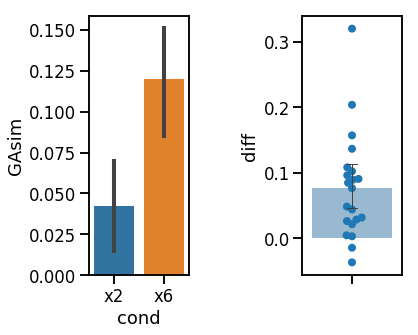

In [30]:
meanSimilarities_allROIs_piv = meanSimilarities_allROIs.pivot(
    index='sub',columns='cond',values='GAsim').reset_index()
meanSimilarities_allROIs_piv['diff'] = meanSimilarities_allROIs_piv['x6']-meanSimilarities_allROIs_piv['x2']
fig,ax = plt.subplots(1,2,figsize=[6,5])
sns.barplot(data=meanSimilarities_allROIs,y='GAsim',x='cond',ax=ax[0])
# for sub in range(20):
#     ax[0].plot([0,1],sumSimilarities.loc[sumSimilarities['sub']==sub,'GAsim'],
#             color='k',lineWidth=1,lineStyle=':')
sns.barplot(data=meanSimilarities_allROIs_piv,y='diff',alpha=.5,errwidth=1,capsize=.1,zorder=1,ax=ax[1])
sns.swarmplot(data=meanSimilarities_allROIs_piv,y='diff',zorder=2,s=8,alpha=1,ax=ax[1])
plt.tight_layout()

In [31]:
print scipy.stats.ttest_rel(meanSimilarities_allROIs.loc[meanSimilarities_allROIs['cond']=='x2','GAsim'],
                            meanSimilarities_allROIs.loc[meanSimilarities_allROIs['cond']=='x6','GAsim'])
print scipy.stats.wilcoxon(meanSimilarities_allROIs.loc[meanSimilarities_allROIs['cond']=='x2','GAsim'],
                            meanSimilarities_allROIs.loc[meanSimilarities_allROIs['cond']=='x6','GAsim'],)
print one_sample_permutation(meanSimilarities_allROIs_piv['diff'])

Ttest_relResult(statistic=-4.36542577879069, pvalue=0.0002994318606611634)
WilcoxonResult(statistic=11.0, pvalue=0.00028104304823949435)
{'p': 0.0002, 'mean': 0.07716500917340137}


#### Simple classification as test (forced choice)

In [32]:
pred = [np.argmax(np.array(meanSimilarities_allROIs.loc[meanSimilarities_allROIs['sub']==i,'GAsim'])) 
        for i in meanSimilarities_allROIs['sub'].unique()]
acc = np.mean(pred)
print acc

print ss.ttest_1samp(pred,.5)

print one_sample_permutation(np.array(pred)-.5)

0.9047619047619048
Ttest_1sampResult(statistic=6.1665481259351, pvalue=5.0343848700138295e-06)
{'p': 0.0004, 'mean': 0.40476190476190477}


In [33]:
acc*nMO

19.0

## Summarize over parcels: split by parcel set unique to GA/IA

In [36]:
nMO = len(dat_MO_x2)
meanSimilarities_perStrategy = pd.DataFrame(columns=['sub','map','cond','GAsim'])
for subInd in range(nMO):
    for parcelSetName, parcelSet in zip(['GA','IA'],[parcelsGAonly,parcelsIAonly]):
        subDat = sim_zdiffs_all.loc[(sim_zdiffs_all['sub']==subInd) & (
            sim_zdiffs_all['parcel'].isin(parcelSet))].copy()
        for cond in ['x2','x6']:
            subSim = np.mean(subDat.loc[subDat['Condition']==cond,'GA > IA similarity'])
            meanSimilarities_perStrategy = meanSimilarities_perStrategy.append(
                pd.DataFrame([[subInd,parcelSetName,cond,subSim]],columns=['sub','map','cond','GAsim']))
meanSimilarities_perStrategy.head()

,sub,map,cond,GAsim
0,0,GA,x2,0.304910
0,0,GA,x6,0.154761
0,0,IA,x2,0.021450
0,0,IA,x6,0.020518
0,1,GA,x2,0.065283


In [37]:
meanSimilarities_perStrategy_piv = meanSimilarities_perStrategy.pivot_table(
    index=['sub','map'],columns='cond',values='GAsim').reset_index()
meanSimilarities_perStrategy_piv['diff'] = meanSimilarities_perStrategy_piv['x6']-meanSimilarities_perStrategy_piv['x2']
meanSimilarities_perStrategy_piv.head()

cond,sub,map,x2,x6,diff
0,0,GA,0.304910,0.154761,-0.150149
1,0,IA,0.021450,0.020518,-0.000932
2,1,GA,0.065283,0.108393,0.043110
3,1,IA,-0.034819,-0.069762,-0.034943
4,2,GA,0.372964,0.349322,-0.023642


In [38]:
x2All = scipy.stats.ttest_1samp(meanSimilarities_allROIs.loc[meanSimilarities_allROIs['cond']=='x2','GAsim'],0)
x6All = scipy.stats.ttest_1samp(meanSimilarities_allROIs.loc[meanSimilarities_allROIs['cond']=='x6','GAsim'],0)
x2GAdat = meanSimilarities_perStrategy.loc[(meanSimilarities_perStrategy['cond']=='x2')
                & (meanSimilarities_perStrategy['map']=='GA'),'GAsim']
x2GA = scipy.stats.ttest_1samp(x2GAdat,0)
x6GAdat = meanSimilarities_perStrategy.loc[(meanSimilarities_perStrategy['cond']=='x6')
                & (meanSimilarities_perStrategy['map']=='GA'),'GAsim']
x6GA = scipy.stats.ttest_1samp(x6GAdat,0)
x2IAdat = meanSimilarities_perStrategy.loc[(meanSimilarities_perStrategy['cond']=='x2')
                & (meanSimilarities_perStrategy['map']=='IA'),'GAsim']
x2IA = scipy.stats.ttest_1samp(x2IAdat,0)
x6IAdat = meanSimilarities_perStrategy.loc[(meanSimilarities_perStrategy['cond']=='x6')
                & (meanSimilarities_perStrategy['map']=='IA'),'GAsim']
x6IA = scipy.stats.ttest_1samp(x6IAdat,0)
print x2All
print x6All
print np.mean(x2GAdat),x2GA
print np.mean(x6GAdat),x6GA
print np.mean(x2IAdat),x2IA
print np.mean(x6IAdat),x6IA

Ttest_1sampResult(statistic=2.9859167622265645, pvalue=0.007303675132276647)
Ttest_1sampResult(statistic=6.789085197339352, pvalue=1.3331515357860784e-06)
0.24809467416666667 Ttest_1sampResult(statistic=8.573027734834596, pvalue=3.9388154431605484e-08)
0.3008224844227381 Ttest_1sampResult(statistic=12.92628784874082, pvalue=3.6143781436637234e-11)
-0.07169237035875001 Ttest_1sampResult(statistic=-4.295906249273056, pvalue=0.00035221717888823484)
0.03372732869166667 Ttest_1sampResult(statistic=1.3248837452495092, pvalue=0.20014881429958123)


In [39]:
diffAll = scipy.stats.ttest_rel(meanSimilarities_allROIs.loc[meanSimilarities_allROIs['cond']=='x6','GAsim'],
                            meanSimilarities_allROIs.loc[meanSimilarities_allROIs['cond']=='x2','GAsim'])
diffGA = scipy.stats.ttest_rel(meanSimilarities_perStrategy.loc[(meanSimilarities_perStrategy['cond']=='x6')
                & (meanSimilarities_perStrategy['map']=='GA'),'GAsim'],meanSimilarities_perStrategy.loc[
    (meanSimilarities_perStrategy['cond']=='x2') & (meanSimilarities_perStrategy['map']=='GA'),'GAsim'])
diffIA = scipy.stats.ttest_rel(meanSimilarities_perStrategy.loc[(meanSimilarities_perStrategy['cond']=='x6')
                & (meanSimilarities_perStrategy['map']=='IA'),'GAsim'],meanSimilarities_perStrategy.loc[
    (meanSimilarities_perStrategy['cond']=='x2') & (meanSimilarities_perStrategy['map']=='IA'),'GAsim'])
print diffAll
print (np.mean(x6GAdat)-np.mean(x2GAdat)),diffGA
print (np.mean(x6IAdat)-np.mean(x2IAdat)),diffIA

Ttest_relResult(statistic=4.36542577879069, pvalue=0.0002994318606611634)
0.052727810256071456 Ttest_relResult(statistic=2.145653225263067, pvalue=0.044356986820743405)
0.10541969905041668 Ttest_relResult(statistic=4.306718405571078, pvalue=0.0003434317630670539)


##### Figure 5

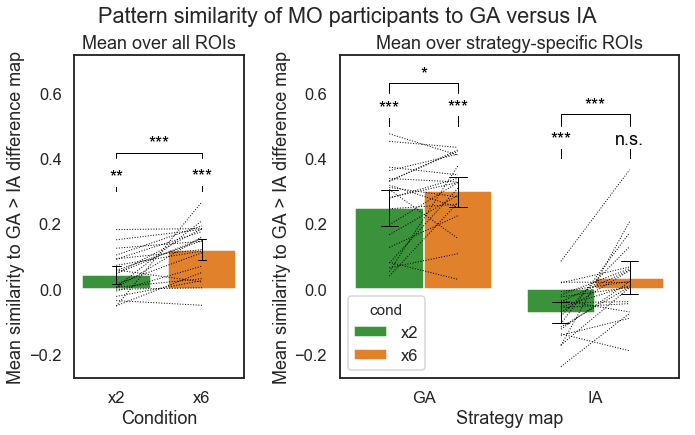

In [40]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
sns.set_context('talk')
sns.set_style('white')
sns.set_palette([sns.color_palette('tab10',3)[i] for i in [2,1]])
fig,ax = plt.subplots(1,2,figsize=[10,6],gridspec_kw={'width_ratios':[1,2]},sharey=False)

sns.barplot(data=meanSimilarities_allROIs,y='GAsim',x='cond',ax=ax[0],
           errcolor='k',errwidth=1,capsize=.1)
for sub in range(nMO):
    ax[0].plot([0,1],meanSimilarities_allROIs.loc[meanSimilarities_allROIs['sub']==sub,'GAsim'],
            color='k',lineWidth=1,lineStyle=':')
ax[0].set(xlabel='Condition',ylabel='Mean similarity to GA > IA difference map',
         title='Mean over all ROIs')

sns.barplot(data=meanSimilarities_perStrategy,y='GAsim',x='map',hue='cond',ax=ax[1],
           errcolor='k',errwidth=1,capsize=.1)
for sub in range(nMO):
    for x,parcelSetName in zip([0,1],['GA','IA']):
        ax[1].plot([x-.2,x+.2],meanSimilarities_perStrategy.loc[(meanSimilarities_perStrategy['sub']==sub) & (
            meanSimilarities_perStrategy['map']==parcelSetName),'GAsim'],color='k',lineWidth=1,lineStyle=':')
ax[1].set(xlabel='Strategy map',ylabel='Mean similarity to GA > IA difference map',
         title='Mean over strategy-specific ROIs')

FigureTools.add_sig_markers(ax[0],relationships=[[0,0,x2All[1]]],ystart = .3)
FigureTools.add_sig_markers(ax[0],relationships=[[1,1,x6All[1]]],ystart = .3)
FigureTools.add_sig_markers(ax[0],relationships=[[0,1,diffAll[1]]],linewidth=1,ystart=.4)
FigureTools.add_sig_markers(ax[1],relationships=[[-.2,-.2,x2GA[1]]],ystart = .5)
FigureTools.add_sig_markers(ax[1],relationships=[[.2,.2,x6GA[1]]],ystart = .5)
FigureTools.add_sig_markers(ax[1],relationships=[[.8,.8,x2IA[1]]],ystart = .4)
FigureTools.add_sig_markers(ax[1],relationships=[[1.2,1.2,x6IA[1]]],ystart = .4)
FigureTools.add_sig_markers(ax[1],relationships=[[-.2,.2,diffGA[1]]],linewidth=1,ystart=.6)
FigureTools.add_sig_markers(ax[1],relationships=[[.8,1.2,diffIA[1]]],linewidth=1,ystart=.5)
# 
# Equalize ylim
ylim0 = ax[0].get_ylim()
ylim1 = ax[1].get_ylim()
ylim = [np.min([ylim0[0],ylim1[0]]),np.max([ylim0[1],ylim1[1]])]
ax[0].set_ylim(ylim); ax[1].set_ylim(ylim);

plt.suptitle('Pattern similarity of MO participants to GA versus IA',y=1.02)
plt.tight_layout();

plt.savefig(os.path.join(base_dir,'Results/5.fMRI-MOswitching,
        'MO-similarity_AllROIs_ByStrategy.pdf'),
        transparent=True, bbox_inches='tight')